## Kaggle - Digit Recognizer


> Blok z wcięciem W tym konkursie stworozny program miał za zadnaie rozpoznać odręcznie napisane cycfry od 0 do 9. Do tego celu wykorzystałam metodę głebokich sieci konwolucyjnych CNN.



Konfiguracja

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [21]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c digit-recognizer

In [285]:


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

Ładowanie baz danych

In [226]:

train = pd.read_csv("/content/train.csv.zip")
test = pd.read_csv("/content/test.csv.zip")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Sprawdzam czy występują dane typu NaN

In [227]:
test.isnull().sum().describe()

count    784.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [228]:
train.isnull().sum().describe()


count    785.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

Sprawdzam liczbe pikseli i liczbe obrazków przypisanych dla danych testowych i danych do uczenia

In [229]:
print("Dane do uczenia")
print("Liczba pikseli każdego obrazka:",(train.shape[1]))
print("Liczba obrazków :",train.shape[0])

Dane do uczenia
Liczba pikseli każdego obrazka: 785
Liczba obrazków : 42000


In [230]:
print("Dane do testowania")
print("Liczba pikseli każdego obrazka:",(test.shape[1]))
print("Liczba obrazków :",test.shape[0])

Dane do testowania
Liczba pikseli każdego obrazka: 784
Liczba obrazków : 28000


Stosunek pakietu danych do uczenia a testowania wynosi 6:4

Oznaczam dane w tabeli:
- Y jako etykieta dla numeru kolejnych obrazków do nauki
- X jako etykieta dla kolejnych pikseli obrazka

Pomijam kolumnę label i używam do tego .drop oraz tworzę nowy pakiet danych (x,y) 

In [301]:
X = train.drop(['label'], 1).values
Y = train['label'].values

test_x = test.values

Normalizuje obrazki do skali szarości w zakresie od 0 do 255, aby ułatwić rozpoznawanie kształtu 

In [302]:
X = X / 255.0
test_x = test_x / 255.0

Następnie zmieniam wymiary obrazków przy użyciu funkcji z biblioteki numpy - reshape, na 28x28 pikseli oraz skale szarości (kanał = 1)

In [303]:
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

Zamienione zostają następnie wartości y w "one-hot" wektory (czyli przekształcone na kod 1 z n). Ze względu na jednoznaczność wektorów, taka zamiana przyspiesza proces odczytu i identyfikacji danych.

In [304]:

Y = to_categorical(Y, num_classes = 10)
print(f"Label size {Y.shape}")


Label size (42000, 10)


Dodatkowo, pakiety danych do uczenia i testowania zostają podzielone, aby poprawić rozkład stosunek pakietów (obecnie wynosi 6:4). Zazwyczaj przyjmuje się, aby zestaw danych do uczenia był co najmiej 80% dostępnej puli danych.

In [305]:

random_seed = 2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=random_seed)
print("Po podziale")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Po podziale


((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

**Wizualizacja danych**

In [306]:
Xtrain = X_train.reshape(X_train.shape[0], 28, 28)

Funkcja shape pozwala na wyznaczenie wymiarów tablicy, a reshape na zmnaianę wymiarów tablicy bez zmiany jej zawartości.

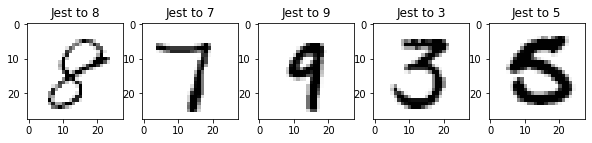

In [307]:
fig, osie = plt.subplots(1, 5, figsize=(10, 10))
for i, c in enumerate(osie.flat):
    c.imshow(Xtrain[i], cmap='binary')
    cyfra = y_train[i].argmax()
    c.set(title = f"Jest to {cyfra}");

**Metoda Głębokich Sieci Konwolucyjnych CNN**

To sieci, które potrafią stopniowo filtrować różne części danych i odrzucać nieodpwoiednie cechy, a wysotrzać ważne w procesie dyskryminacji 

Poniższy model składa się z 3 warstw. Pierwsze dwie (wartswy konowlucyjne) składają się z filtrów o określonej szerokości i wysokości. Każdy z filtrów analizuje określoną część obrazu, a wymiar tej części jest określony przez wspomnianą szerokość i wsyokość ( w kodzie - kernel size ). Warstwa łącząca jest tworzona przy pomocy funkcji MaxPool2D, która służy do progresywnej redukcji rozmiaru przestrzennego przez co do zredukowania ilości cech.
Funkcja 'relu' powoduje,że sieć nie jest liniowa.
Ostatnia warstwa z funkcją 'Flatten' konwertuje końcową mapę cech w pojedynczy, jednowymiarowy wektor.

In [308]:

model = Sequential()
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Do kompilacji modelu wykorzystałam optymalizator ADAM (Adaptive Moment Estimation).

In [309]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Proces uczenia wywołuje metodą fit, która przyjmuje dwa podstawowe parametry (poza zbiorem danych i etykiet): batch_size (liczbę próbek) i epochs (epoki).

In [312]:
history=model.fit(X,Y,batch_size=8,epochs=4,validation_split=.2)

Epoch 1/4
4200/4200 [==============================] - 301s 71ms/step - loss: 0.1875 - accuracy: 0.9463 - val_loss: 0.0929 - val_accuracy: 0.9787
Epoch 2/4
4200/4200 [==============================] - 299s 71ms/step - loss: 0.0983 - accuracy: 0.9722 - val_loss: 0.0444 - val_accuracy: 0.9885
Epoch 3/4
4200/4200 [==============================] - 300s 71ms/step - loss: 0.0733 - accuracy: 0.9785 - val_loss: 0.0518 - val_accuracy: 0.9837
Epoch 4/4
4200/4200 [==============================] - 299s 71ms/step - loss: 0.0612 - accuracy: 0.9826 - val_loss: 0.0506 - val_accuracy: 0.9883


Otzrymane dane w tym - błąd uczenia, błąd walidacji, wktórym zostały użyte dane testowe. 

---



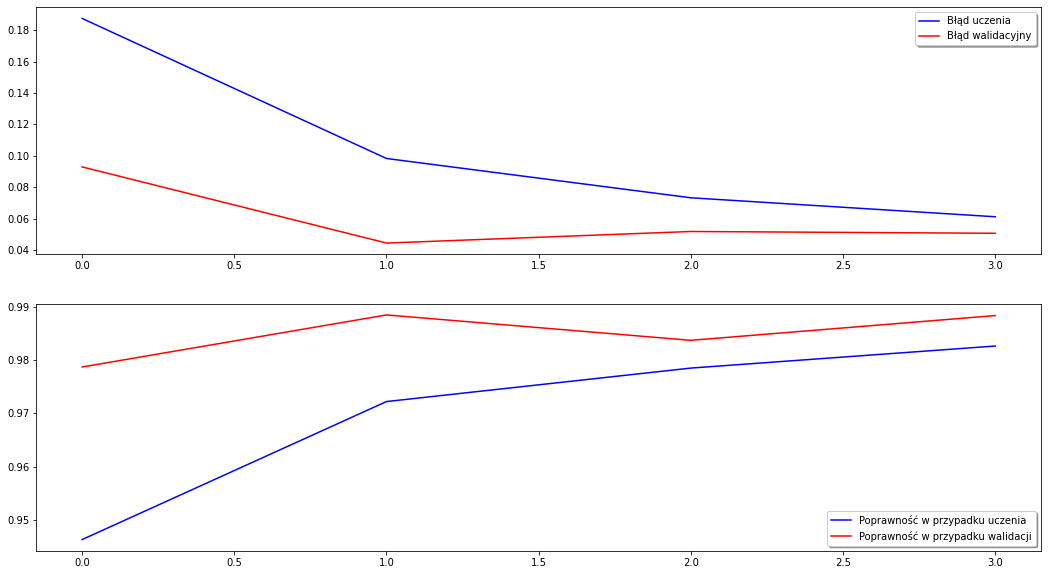

In [314]:

fig, oś = plt.subplots(2,1, figsize=(18, 10))
oś[0].plot(history.history['loss'], color='b', label="Błąd uczenia")
oś[0].plot(history.history['val_loss'], color='r', label="Błąd walidacyjny",axes =oś[0])
legend = oś[0].legend(loc='best', shadow=True)

oś[1].plot(history.history['accuracy'], color='b', label="Poprawność w przypadku uczenia")
oś[1].plot(history.history['val_accuracy'], color='r',label="Poprawność w przypadku walidacji")
legend = oś[1].legend(loc='best', shadow=True)

Dla powyższego procesu uczenia otrzymałam poprawność na poziomie 0.97. Należałoby powtórzyć uczenie dla wiekszej liczby epok.

In [329]:
y_prze = model.predict(test_x)
X_test__ = test_x.reshape(test_x.shape[0], 28, 28)


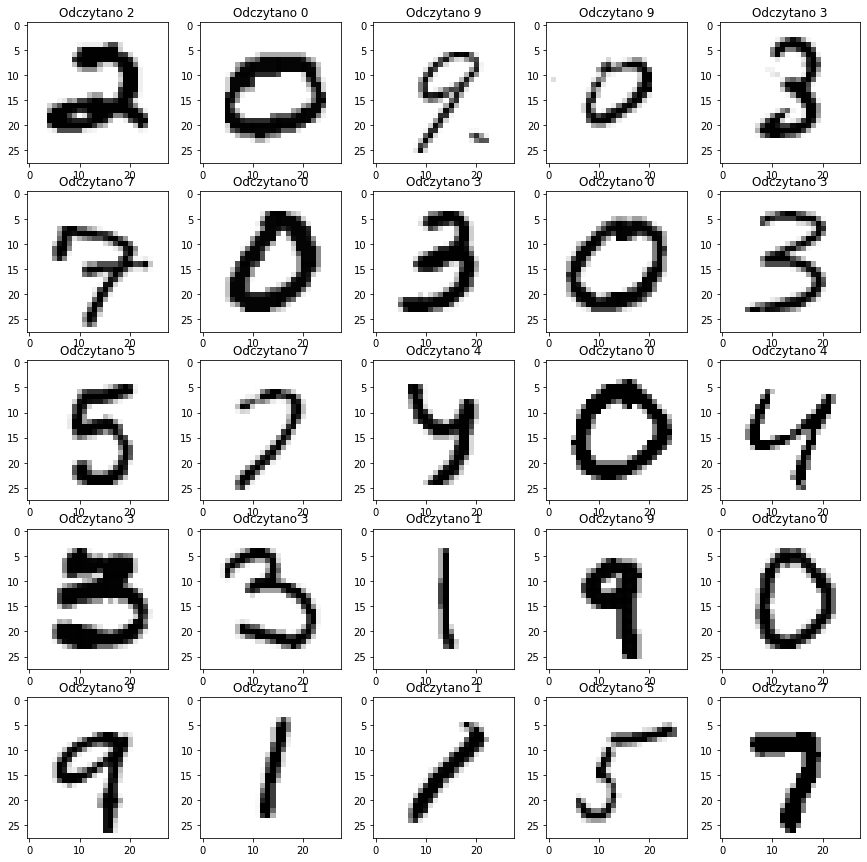

In [330]:
fig, axis = plt.subplots(5, 5, figsize=(15,15))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Odczytano {y_prze[i].argmax()}")

Z powyższch grafik widać,że w większości przypadków program dobrze odczytuje cyfry. Nie radzi sobie z odczytywaniem 0. Dla zwiększenia poprawności odczytu należałoby wykonać uczenie dla większej liczby epok oraz z uczeniem dla bazy danych, w której obrazki są np. obrócone.